# **Bias measuring and mitigation in regression tasks**

The bias problem can appear in models when the predictions systematically deviate from the true values for certain subgroups in the dataset. This phenomenon can occur due to various reasons such as unbalanced groups in the training data, feature selection, or model specification. Because of this, the bias problem can appear in different tasks, being "regression task" one of them. 

There are various techniques to measure bias in regression tasks. One common approach is to use fairness metrics such as demographic parity, equalized odds, or equal opportunity, which quantify the differences in the model's performance across different subgroups based on sensitive attributes such as gender or race.

Once bias is detected, we can employ different techniques to mitigate it. These methods can be grouped into three categories: Pre-processing, in-processing and post-processing methods. Pre-processing techniques are used to adjust the training data to remove bias, while in-processing methods are applied to build robust models against bias. Finally, post-processing techniques are used to adjust the model's predictions to remove bias.

Through this tutorial, we pretend to present you tools which can be easily applied to measure and mitigate the presence of bias in regression models.

We will follow the traditional outline for this tutorial:

1. Data loading and packages installation
2. Dataset preprocessing
3. Data analysis
4. Model training
5. Bias measuring
6. Bias mitigation
7. Results comparison

## **1. Data loading and packages installation**

First of all, we need to import the required packages to perform our bias analysis and mitigation. You will need to have the `holisticai` package installed on your system, remember that you can install it by running: 
```bash
!pip install holisticai[all]
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

In [2]:
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

## **2. Dataset preprocessing**

The dataset that we will use is the "Communities and Crime" dataset which is a publicly available dataset that contains socio-economic and law enforcement data for 1994 communities in the United States. This dataset contains demographic variables such as population size, race, and education level, as well as variables related to law enforcement. The objective is to predict the crime rate per capita in each community.

Source: [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/communities+and+crime)

In [3]:
from holisticai.datasets import load_dataset

To speed up the process, the `load_dataset` function of the *holisticai* package allows to return the raw dataset or the preprocessed dataset by setting the `preprocess` parameter to `True`. This function also allows to return the dataset and the protected as a pandas dataframe or as a numpy array. You will find more information about the target and the protected groups of this function in its documentation.

In this tutorial, we will use the preprocessed dataset as a pandas dataframe.

In [17]:
df, group_a, group_b = load_dataset(dataset='crime', preprocessed=True, as_array=False)

In [18]:
df.isna().sum()

population             0
householdsize          0
numbUrban              0
pctUrban               0
medIncome              0
                      ..
LandArea               0
PopDens                0
PctUsePubTrans         0
LemasPctOfficDrugUn    0
ViolentCrimesPerPop    0
Length: 93, dtype: int64

Now that we have a clean dataset we can start defining the protected groups and the training and testing sets.

## **3. Data analysis**

Since this function already return the protected groups, we can start with the data analysis step. In this step, we will analyze the distribution of the data of the protected groups by using the `group_pie_plot` function. This function will plot the distribution of the data of the protected groups in a pie chart.

<Axes: >

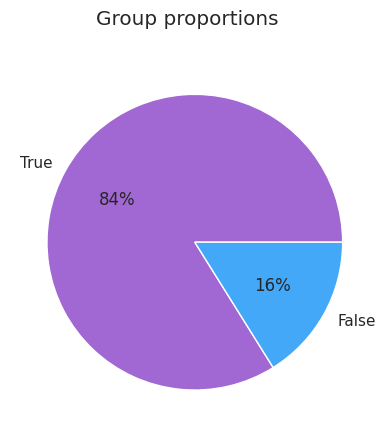

In [19]:
from holisticai.plots.bias import group_pie_plot

group_pie_plot(group_a)

This graph show us that the proportion of white people (labelled as *True*) is very high compared to the remain races.

Let's plot the columns with the highest correlations with respect to the target variable. To do this, we will use the `correlation_matrix_plot` function. 

<Axes: >

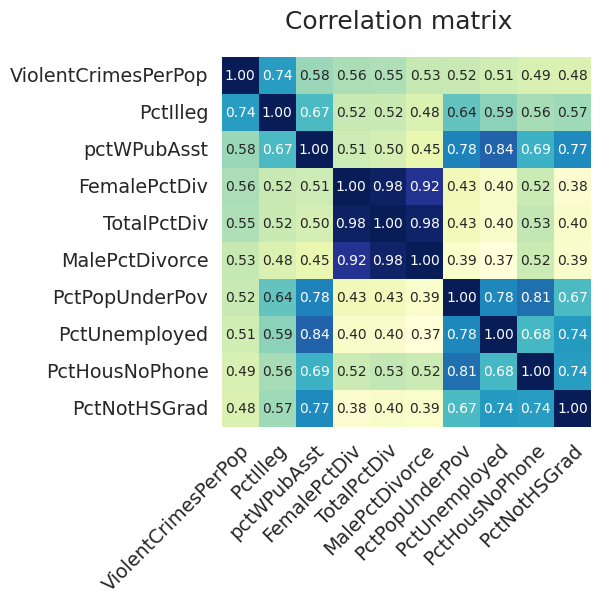

In [20]:
from holisticai.plots.bias import correlation_matrix_plot

correlation_matrix_plot(df, target_feature="ViolentCrimesPerPop", n_features=10)

In [21]:
X = df.values[:,:-1]
y = df.values[:,-1]

X.shape, y.shape

((1993, 92), (1993,))

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

To obtain properly values with the mitigator, we scale the objective column:

In [23]:
scaler = StandardScaler()
y = scaler.fit_transform(y.reshape(-1, 1))
y = np.squeeze(y)

In [24]:
X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
    train_test_split(X, y, group_a, group_b, test_size=0.3, random_state=100)
train_data = X_train, y_train, group_a_tr, group_b_tr
test_data  = X_test, y_test, group_a_ts, group_b_ts

## **4. Model training**

Once we have defined the input and output sets, we can train a model as usual. Since the protected groups were separated from the dataset previously we do not need to take care of that in this opportunity, but do not forget to separate the protected attributes from the dataset, so that the model does not have any influence from these attributes in its training process. For the training process, we will use a traditional pipeline, we will fit and re-scale the training data, and then we will use the data to train a "Linear regression" model. When the model has been trained, we can use the predictions to calculate the fairness metrics of the model.

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from holisticai.pipeline import Pipeline

In [26]:
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train a simple linear regression model
LR = LinearRegression()
model = LR.fit(X, y)

X, y, group_a, group_b = test_data

X = scaler.transform(X)

# Predict values
y_pred = model.predict(X)

# Calculate the error
baseline_rmse = mean_squared_error(y, y_pred, squared=False)
print("RMS error: {}".format(baseline_rmse))

RMS error: 0.5864697199928485


The fairness of the model can be calculated using the predictions of the model and the protected groups defined previously. The `holisticai` contains a module that calculates a set of metrics useful in evaluating the fairness of algorithmic decisions. For our case, we will use the `regression_bias_metrics` function which allows us to select which metrics we want to calculate, if `equal_outcome`, `equal_opportunity` or `both`, where equal_outcome shows how disadvantaged groups are treated by the model and equal_opportunity shows if all the groups have the same opportunities.

In [27]:
from holisticai.metrics.bias import regression_bias_metrics

In [28]:
df = regression_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
y_baseline = y_pred.copy()
df_baseline=df.copy()
df_baseline

,Value,Reference
Metric,,
Disparate Impact Q90,0.017601,1
Disparate Impact Q80,0.116168,1
Disparate Impact Q50,0.422241,1
Statistical Parity Q50,-0.683376,0
No Disparate Impact Level,-0.757714,-
Average Score Difference,-1.583636,0
Average Score Ratio,-0.203326,1
Z Score Difference,-2.493148,0
Max Statistical Parity,0.732576,0


For example:

*   **Disparate Impact Q:** Shows the ratio of success rates between the protected groups for a certain quantile. Values below 1 are unfair towards `group_a`. Values above 1 are unfair towards `group_b`. The range (0.8, 1.2) is considered acceptable.
*   **Statistical parity:** Computes the difference in success rates between the protected groups. Values below 0 are considered unfair towards `group_a` while values above 0 are considered unfair towards `group_b`.
*   **Average score difference:** Computes the difference in average scores between the protected groups. Negative values indicate that `group_a` has a lower average score, so bias against `group_a`, while positive values indicate `group_b` has a lower average score, so bias against `group_b`.
*   **Z score difference:** Computes the spread in Zscores between the protected groups, the Zscore is a normalised version of Disparate Impact.
*   **Max Statistical Parity:** Computes the maximum overall thresholds of the absolute statistical parity between the protected groups, values below 0.1 in absolute value are considered acceptable.
*   **RMSE ratio:** Computes the RMSE for the protected groups, lower values show bias against `group_a` while higher values show bias against `group_b`.
*   **MAE ratio:** Similar to the previous metric, computes the MAE for the protected groups, lower values show bias against `group_a` while higher values show bias against `group_b`.
*   **Correlation difference:** Computes the difference in correlation between predictions and targets for the protected groups, positive values show bias against `group_a` while negative values show bias against `group_b`.


Source: [*HolisticAI docs*](https://holisticai.readthedocs.io/en/latest/metrics.html#regression)

## **6. Bias mitigation**
### **Postprocessing - Plugin estimator and calibrator**

Now that we could observe that the model metrics are far away from the desired values, we need to apply some kind of strategy to mitigate the bias present in the model.

Exists different kinds of strategies, and the literature has divided them into three categories: *Pre-processing*, *in-processing* and *post-processing* methods. The `holisticai` library possesses different algorithms from these categories for bias mitigation. An interesting feature is that all of them are compatible with the `Scikit-learn` package, so that, if you are familiar with this package, you will not have problems using the library. As you will see later, its implementation can be done following the traditional way, or by applying the pipeline. 

For this opportunity, we will implement the "Plugin estimator and calibrator" method which is an post-processing technique that optimizes over calibrated regressor outputs via a smooth optimization. Moreover the rates of convergence of the proposed estimator are derived in terms of the risk and fairness constraint.

### **Traditional implementation**

In [29]:
from holisticai.mitigation.bias import PluginEstimationAndCalibration

In [30]:
model = LinearRegression()
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

model.fit(X, y)
y_pred = model.predict(X)

post_processer = PluginEstimationAndCalibration()
post_processer.fit_transform(y_pred, group_a, group_b)

X, y, group_a, group_b = test_data

X = scaler.transform(X)

y_pred = model.predict(X)

y_pred = post_processer.transform(y_pred, group_a, group_b)['y_pred']

print(y.shape)

df = regression_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
y_pec  = y_pred.copy()
df_pec =df.copy()
df_pec

(598,)


,Value,Reference
Metric,,
Disparate Impact Q90,0.290419,1
Disparate Impact Q80,0.640925,1
Disparate Impact Q50,1.000000,1
Statistical Parity Q50,-0.107352,0
No Disparate Impact Level,0.291667,-
Average Score Difference,-0.078676,0
Average Score Ratio,0.730254,1
Z Score Difference,-0.235603,0
Max Statistical Parity,0.207503,0


In [53]:
pec_rmse = mean_squared_error(y, y_pred, squared=False)
print("RMS error: {}".format(pec_rmse))

RMS error: 0.8779320431747413


### **Pipeline implementation**

Now that we could see how this method is implemented traditionally, let's try implementing it by using the Scikit-learn Pipeline! Notice that we shouldn't have variations in the metrics for the previous implementation.

In [26]:
model = LinearRegression()
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("model", model),
        ("bm_postprocessing", PluginEstimationAndCalibration()),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a, 
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)
df = regression_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
y_pec  = y_pred.copy()
df_pec_w_p =df.copy()
df_pec_w_p

,Value,Reference
Metric,,
Disparate Impact Q90,0.290419,1
Disparate Impact Q80,0.640925,1
Disparate Impact Q50,1.000000,1
Statistical Parity Q50,-0.107352,0
No Disparate Impact Level,0.291667,-
Average Score Difference,-0.078676,0
Average Score Ratio,0.730254,1
Z Score Difference,-0.235603,0
Max Statistical Parity,0.207503,0


## **7. Results comparison**

Now that we could observe how is the implementation of the mitigator in the model, we will compare the results between the baseline and the implementations with the mitigator to analyse how the metrics have changed.

In [27]:
result = pd.concat([df_baseline, df_pec, df_pec_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Disparate Impact Q90,0.017601,0.290419,0.290419,1
Disparate Impact Q80,0.116168,0.640925,0.640925,1
Disparate Impact Q50,0.422241,1.000000,1.000000,1
Statistical Parity Q50,-0.683376,-0.107352,-0.107352,0
No Disparate Impact Level,-0.757714,0.291667,0.291667,-
Average Score Difference,-1.583636,-0.078676,-0.078676,0
Average Score Ratio,-0.203326,0.730254,0.730254,1
Z Score Difference,-2.493148,-0.235603,-0.235603,0
Max Statistical Parity,0.732576,0.207503,0.207503,0


From the previous chart, we can see that although the actual metrics are still far from the ideal values, an improvement is obtained by applying this method in the dataset, compared with our baseline. 

Notice that we can analyse how these values are affected by varying the hyperparameters of the method.

For example, this method allows us to set different hyperparameters such us grid points and a temperature parameter, you will find more information in its documentation [here](https://holisticai.readthedocs.io/en/latest/.generated/holisticai.mitigation.bias.PluginEstimationAndCalibration.html)

In this opportunity we will try with different temperatures:

In [28]:
def calculate_metrics(train_data, test_data, group_a, group_b, beta, metrics_cols):
  model = LinearRegression()
  pipeline = Pipeline(
      steps=[
          ('scalar', StandardScaler()),
          ("model", model),
          ("bm_postprocessing", PluginEstimationAndCalibration(beta=beta)),
      ]
  )

  X, y, group_a, group_b = train_data
  fit_params = {
      "bm__group_a": group_a, 
      "bm__group_b": group_b
  }

  pipeline.fit(X, y, **fit_params)

  X, y, group_a, group_b = test_data
  predict_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b,
  }
  y_pred = pipeline.predict(X, **predict_params)
  df = regression_bias_metrics(
      group_a,
      group_b,
      y_pred,
      y,
      metric_type='both'
  )
  # Calculate metrics
  metrics = [
      beta, 
      mean_squared_error(y, y_pred, squared=False)
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics

In [29]:
metrics_val = []
metrics_cols = ['Disparate Impact Q80', 'RMSE Ratio', 'MAE Ratio', 'Statistical Parity Q50', 'Average Score Difference', 'Correlation Difference']

for beta in np.linspace(0,1,11):
  metrics_val.append(calculate_metrics(train_data, test_data, group_a, group_b, beta, metrics_cols))

metrics = ['beta', 'RMSE']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

/usr/local/lib/python3.9/dist-packages/holisticai/bias/mitigation/postprocessing/plugin_estimator_and_recalibration/algorithm_utils.py:16: RuntimeWarning: divide by zero encountered in true_divide
  return np.exp(lambda_[i + L] * (2 * S - 1) / beta + H / beta)
/usr/local/lib/python3.9/dist-packages/holisticai/bias/mitigation/postprocessing/plugin_estimator_and_recalibration/algorithm_utils.py:16: RuntimeWarning: invalid value encountered in add
  return np.exp(lambda_[i + L] * (2 * S - 1) / beta + H / beta)
/usr/local/lib/python3.9/dist-packages/holisticai/bias/mitigation/postprocessing/plugin_estimator_and_recalibration/algorithm_utils.py:16: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(lambda_[i + L] * (2 * S - 1) / beta + H / beta)


,beta,RMSE,Disparate Impact Q80,RMSE Ratio,MAE Ratio,Statistical Parity Q50,Average Score Difference,Correlation Difference
0,0.0,0.787789,0.121331,0.637919,0.711374,-0.679384,-0.676670,0.071692
1,0.1,0.877932,0.640925,0.524743,0.592064,-0.107352,-0.078676,0.133351
2,0.2,0.892464,0.814787,0.512613,0.579377,-0.045826,-0.027030,0.168369
3,0.3,0.895535,0.847056,0.515673,0.583756,-0.037842,-0.020460,0.168713
4,0.4,0.916236,1.055190,0.493328,0.566686,0.011379,0.025934,0.289123
5,0.5,0.918581,0.977745,0.495592,0.569639,-0.004589,0.031339,0.287496
6,0.6,0.923554,1.140164,0.492899,0.562387,0.026010,0.055950,0.276741
7,0.7,0.926438,1.230011,0.490390,0.558276,0.040311,0.068505,0.281381
8,0.8,0.926431,1.367390,0.492455,0.564424,0.060600,0.081808,0.238743
9,0.9,0.931410,1.576561,0.489250,0.561806,0.083215,0.105504,0.222848


Text(0.5, 0, 'Temperature value')

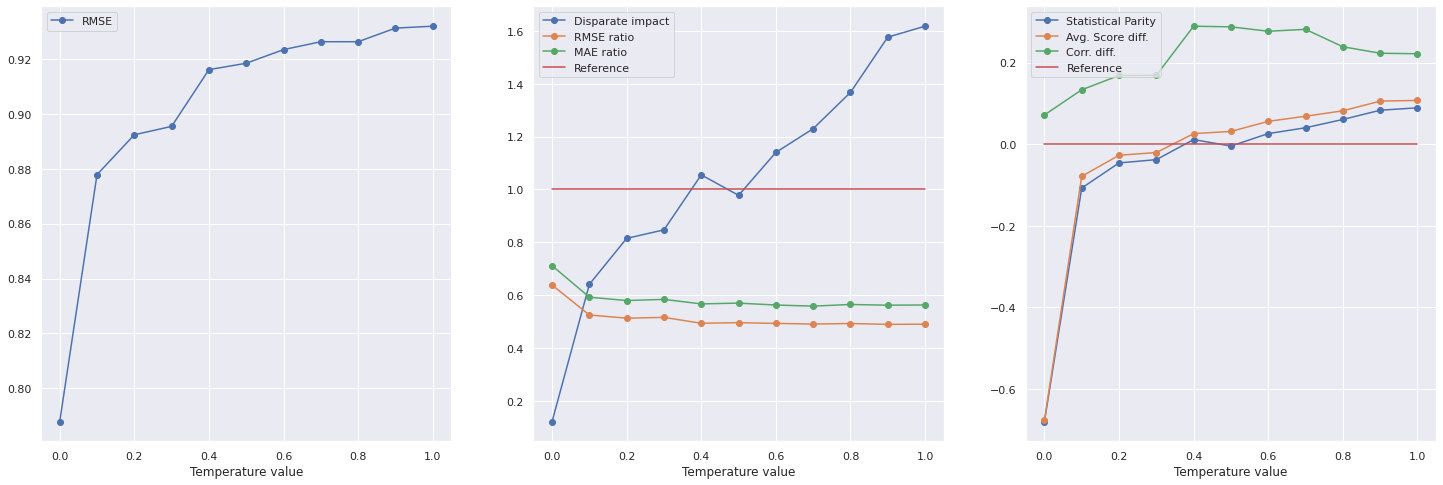

In [30]:
x_axis = df_metrics.beta
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(x_axis, df_metrics.RMSE, 'o-', label='RMSE')
plt.legend(loc='upper left')
plt.xlabel('Temperature value')
plt.subplot(132)
plt.plot(x_axis, df_metrics['Disparate Impact Q80'], 'o-', label='Disparate impact')
plt.plot(x_axis, df_metrics['RMSE Ratio'], 'o-', label='RMSE ratio')
plt.plot(x_axis, df_metrics['MAE Ratio'], 'o-', label='MAE ratio')
plt.plot(x_axis, np.ones_like(df_metrics['MAE Ratio']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('Temperature value')
plt.subplot(133)
plt.plot(x_axis, df_metrics['Statistical Parity Q50'], 'o-', label='Statistical Parity')
plt.plot(x_axis, df_metrics['Average Score Difference'], 'o-', label='Avg. Score diff.')
plt.plot(x_axis, df_metrics['Correlation Difference'], 'o-', label='Corr. diff.')
plt.plot(x_axis, np.zeros_like(df_metrics['Correlation Difference']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('Temperature value')

As we can see, the selection of different values for the temperature parameter will vary its performance, although we can observe that in general terms we achieve a better model in terms of fair by increasing this value, the RMSE will be increased as well.

In general, the selection of the model parameters will depend on our main objective, whether we are looking for fairness or accuracy.

# **Summary**
Through this tutorial we could present to the user how the `holisticai` library can be easily used to measure the bias present in regression models by the application of the `regression_bias_metrics` function, which returns the calculated values for different metrics and their references respectively. 

In addition, we shown how to mitigate the bias by applying some methods, for this opportunity we applied the Plugin estimator and calibrator technique to train a fairness model, this is a post-processing method that optimizes over calibrated regressor outputs via a smooth optimization to improve fairness. Consequently we could observe how the metrics are influenced by varing some hyperparameters, and showing how this method increases the fairness of the model.